data normalization ok
batch normalization ok
momentum learning rate ok
learning rate decay ok
weight initialize ok
dropout ok
weight regularization ok
early stopping ok
focal loss ok
penalty ok

weight pruning

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [3]:
# load dataset
data = pd.read_csv("dataset/preprocessed.csv")
data = data.drop(data[data.target == -1].index)
data.shape

(762094, 44)

In [4]:
# Separate input features and target
targets = data.target
targets -= 1
targets = targets.to_numpy()

In [5]:
features = data.drop('target', axis=1)
features = features.to_numpy()

In [6]:
# split test part
X_trainAndVal, X_test, y_trainAndVal, y_test = train_test_split(features, targets, test_size = 0.25, random_state = 0)

In [7]:
# split train and validation part
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size = 0.25, random_state = 0)

In [8]:
# print distribution before re-sampling
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[     0      1      2      3      4]
 [ 44236  49097  76576 103538 155230]]


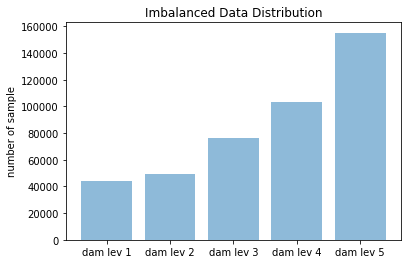

In [9]:
# plot distribution before re-sampling
objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
y_pos = np.arange(len(objects))
plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('number of sample')
plt.title('Imbalanced Data Distribution')
plt.savefig("imbalanced.png")

In [10]:
# re-sampling may use
# sm = SMOTETomek(random_state = 27, n_jobs = -1)
# X_train, y_train = sm.fit_sample(X_train, y_train)

In [11]:
# print distribution after re-sampling
# unique_elements, counts_elements = np.unique(y_train, return_counts=True)
# print("Frequency of unique values of the said array:")
# print(np.asarray((unique_elements, counts_elements)))

In [12]:
# plot distribution after re-sampling
# objects = ('dam lev 1', 'dam lev 2', 'dam lev 3', 'dam lev 4', 'dam lev 5')
# y_pos = np.arange(len(objects))
# plt.bar(y_pos, counts_elements, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.ylabel('number of sample')
# plt.title('After Re-sampling Data Distribution')
# plt.savefig("resample.png")

In [13]:
#Scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [14]:
# calculate weight for targets
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = torch.from_numpy(class_weights)
class_weights

tensor([1.9381, 1.7462, 1.1196, 0.8281, 0.5523], dtype=torch.float64)

In [15]:
# network settings
import sys
epsilon = sys.float_info.epsilon

batch_size = 100000
epochs = 100
input_dim = 43
output_dim = 5
lr = 0.05
momentum_val = 0.9
weight_decay_val = 0.00001

gamma_val = 0.5
prob = 0.1

old_loss = 1 / epsilon
cur_loss = 0.0
best_loss = 1 / epsilon

loss_dicrease_count = 0
loss_dicrease_limit = 3
loss_dicrease_threshold = 0.001

early_stop_epoch = 0

In [16]:
# data load
class datasetLoad(Dataset):
    def __init__(self, features,labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
X_train = datasetLoad(X_train, y_train)
X_val = datasetLoad(X_val, y_val)

In [17]:
# dataLoader
train_loader = torch.utils.data.DataLoader(dataset = X_train, batch_size = batch_size, shuffle=True, num_workers = 1)
val_loader = torch.utils.data.DataLoader(dataset = X_val, batch_size = batch_size, shuffle=True, num_workers = 1)

In [18]:
# focal loss
class FocalLoss(nn.Module):
    def __init__(self, focusing_param = 2, balance_param=0.5):
        super(FocalLoss, self).__init__()
        self.focusing_param = focusing_param
        self.balance_param = balance_param
    def forward(self, output, target):
        cross_entropy = F.cross_entropy(output, target)
        cross_entropy_log = torch.log(cross_entropy)
        logpt = - F.cross_entropy(output, target)
        pt    = torch.exp(logpt)
        focal_loss = -((1 - pt) ** self.focusing_param) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [19]:
# network
class neuralNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden1_dim, hidden2_dim, output_dim, dropout_p):
        super(neuralNetwork, self).__init__()
        
        self.hidden1 = nn.Linear(input_dim, hidden1_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.hidden1.weight)
        self.bnhidden1 = nn.BatchNorm1d(hidden1_dim)
        
        self.hidden2 = nn.Linear(hidden1_dim, hidden2_dim, bias=True) 
        torch.nn.init.xavier_uniform(self.hidden2.weight)
        self.bnhidden2 = nn.BatchNorm1d(hidden2_dim)
        
        self.output = nn.Linear(hidden2_dim, output_dim, bias=True)
        torch.nn.init.xavier_uniform(self.output.weight)

        self.dropout = nn.Dropout(dropout_p)
    def forward(self, x):
        
        x = self.hidden1(x)   
        x = self.dropout(x)
        x = self.bnhidden1(x)        
        x = F.leaky_relu_(x, negative_slope=0.01)
        
        x = self.hidden2(x)        
        x = self.dropout(x)
        x = self.bnhidden2(x)
        x = F.leaky_relu_(x, negative_slope=0.01)
        
        
        outputs = self.output(x)
        return outputs

In [20]:
# create network object
model = neuralNetwork(input_dim, 20, 10, output_dim, prob)

/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


In [21]:
# choose loss function
# criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.CrossEntropyLoss(weight = class_weights.float())
criterion = FocalLoss()

In [22]:
# choose optimizer and learning rate decay
from torch.optim.lr_scheduler import MultiStepLR

# optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = momentum_val, weight_decay = weight_decay_val)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = MultiStepLR(optimizer, milestones=[30, 60, 80], gamma = gamma_val)

In [23]:
# convert network to CUDA
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [24]:
feature_train, label_train = next(iter(train_loader))
if torch.cuda.is_available():
    feature_train = feature_train.cuda()
grid_train = torchvision.utils.make_grid(feature_train)

In [25]:
# create Tensorboard object
tb = SummaryWriter('runs')

In [26]:
# Upload network and example to Tensorboard
tb.add_image("features", grid_train)
tb.add_graph(model, feature_train.float())

In [27]:
# apply neural network
import datetime
a = datetime.datetime.now().replace(microsecond=0)
train_loss = []
validation_loss = []
for epoch in range(epochs):
    train_loss_val = 0.0
    train_counter = 0
    validation_loss_val = 0.0
    val_counter = 0
    accuracy = 0.0
    for i, (features_train, labels_train) in enumerate(train_loader):
        features_train = Variable(features_train)
        labels_train = Variable(labels_train)
        if torch.cuda.is_available():
            features_train = features_train.cuda()
            labels_train = labels_train.cuda()        
        optimizer.zero_grad()
        outputs_train = model(features_train.float())
        loss_train = criterion(outputs_train.float(), labels_train)
        loss_train.backward()
        optimizer.step()
        train_loss_val += loss_train.item()
        train_counter += 1
        del features_train
        del labels_train        
        torch.cuda.empty_cache()
        
    train_loss_val /= train_counter    
           
    for i, (features_val, labels_val) in enumerate( val_loader):
        features_val = Variable(features_val)
        labels_val = Variable(labels_val)
        if torch.cuda.is_available():
            features_val = features_val.cuda()
            labels_val = labels_val.cuda() 
        with torch.no_grad():
            outputs_val = model(features_val.float())
        loss_val = criterion(outputs_val.float(), labels_val)
        validation_loss_val += loss_val.item()
        _, predicted = torch.max(outputs_val.data, 1)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        accuracy += f1_score(labels_val.cpu(), predicted.cpu(), average = 'weighted') * 100
        val_counter += 1
        del features_val
        del labels_val          
        torch.cuda.empty_cache()
        
    validation_loss_val /= val_counter
    accuracy /=  val_counter
        
    cur_loss = validation_loss_val
    
    if(cur_loss < best_loss):
        torch.save(model.state_dict(), 'weights_only.pth')
        early_stop_epoch = epoch
        best_loss = cur_loss
        
    if(cur_loss > old_loss + loss_dicrease_threshold):
        loss_dicrease_count += 1
        
    if(cur_loss + loss_dicrease_threshold < old_loss):
        loss_dicrease_count = 0
        
    if(loss_dicrease_count == loss_dicrease_limit):
        print("--------------------\n\n\nYOU NEED STOP\n\n\n\n----------")
        break
    
    old_loss = cur_loss
       
    scheduler.step()
     
    
    train_loss.append(train_loss_val)
    validation_loss.append(validation_loss_val)
    if(epoch % 20 == 0):
        print("{")
        print("Epoch: {}. Train Loss: {}. ".format(epoch, train_loss_val))
        print("Epoch: {}. Validation Loss: {}. Validation Accuracy: {}.".format(epoch, validation_loss_val, accuracy))
        print("}")
        
    tb.add_scalar("Train Loss ", train_loss_val, epoch)
    tb.add_scalar("Validation Loss ", validation_loss_val, epoch)
    tb.add_scalar("Validation Accur ", accuracy, epoch) 
        
    for name, weight in model.named_parameters():
        tb.add_histogram(name, weight, epoch)
        tb.add_histogram(f'{name}.grad', weight.grad, epoch)
    
tb.close()

{
Epoch: 0. Train Loss: 0.5097930550575256. 
Epoch: 0. Validation Loss: 0.40167586505413055. Validation Accuracy: 27.41515136858753.
}
{
Epoch: 20. Train Loss: 0.321930992603302. 
Epoch: 20. Validation Loss: 0.32288913428783417. Validation Accuracy: 39.49070996590237.
}
{
Epoch: 40. Train Loss: 0.315349942445755. 
Epoch: 40. Validation Loss: 0.3168076276779175. Validation Accuracy: 40.31294105655663.
}
{
Epoch: 60. Train Loss: 0.3129290759563446. 
Epoch: 60. Validation Loss: 0.3157006949186325. Validation Accuracy: 41.031949550582326.
}
{
Epoch: 80. Train Loss: 0.3123372972011566. 
Epoch: 80. Validation Loss: 0.31478723883628845. Validation Accuracy: 41.09559046216939.
}


In [28]:
# calculate time difference and give warning when the epochs finish
b = datetime.datetime.now().replace(microsecond=0)
print(b-a)
import os,time
counter = 0
while(counter < 1):
    os.system('spd-say "your program has finished"')
    time.sleep(3)
    counter += 1

0:07:10


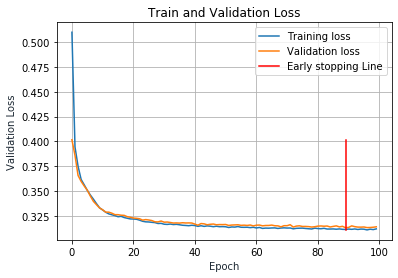

In [29]:
# plotting the training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
x = np.full([2], early_stop_epoch, dtype = int)
y = np.linspace(min(train_loss), max(validation_loss), 2) 
plt.plot(x, y, '-r', label='Early stopping Line')
plt.title('Train and Validation Loss')
plt.xlabel('Epoch', color='#1C2833')
plt.ylabel('Validation Loss', color='#1C2833')
plt.legend(loc='upper left')
plt.legend()
plt.grid()
# plt.show()
plt.savefig("loss.png")

In [30]:
# print the early stopping epoch and create a new network
print(early_stop_epoch)
the_model = neuralNetwork(input_dim, 20, 10, output_dim, prob)

89


/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  import sys
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  # This is added back by InteractiveShellApp.init_path()
/home/emreunel/anaconda3/envs/ass3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  from ipykernel import kernelapp as app


In [31]:
if torch.cuda.is_available():
    the_model = the_model.cuda()

In [32]:
# load best weight to new network
the_model.load_state_dict(torch.load("weights_only.pth"))

<All keys matched successfully>

In [33]:
X_test  = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

In [34]:
if torch.cuda.is_available():
    X_test = X_test.cuda()
    y_test = y_test.cuda() 

In [35]:
# calculate test results
with torch.no_grad():
    outputs = the_model(X_test.float())
_, predicted = torch.max(outputs.data, 1)

In [36]:
# print results
print("Accuracy: \t", accuracy_score(y_test.cpu(), predicted.cpu()))
print("F1 Score: \t", f1_score(y_test.cpu(), predicted.cpu(), average = 'weighted'))
print("Precision:\t", precision_score(y_test.cpu(), predicted.cpu(), average = 'weighted'))
print("Recall:   \t", recall_score(y_test.cpu(), predicted.cpu(), average = 'weighted'))

Accuracy: 	 0.46310701014045474
F1 Score: 	 0.41290069496309384
Precision:	 0.4142764473840717
Recall:   	 0.46310701014045474


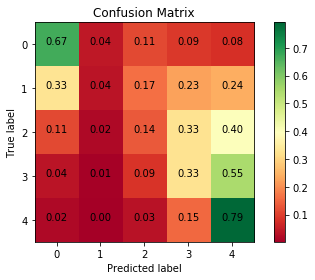

In [37]:
# show confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.cpu(), predicted.cpu())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm, interpolation='nearest',cmap="RdYlGn")
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(5):
    for j in range(5):
        plt.text(j,i,format(cm[i][j],".2f"),horizontalalignment="center",color="black")
plt.tight_layout()
# plt.show()
plt.savefig("confusion.png")